In [2]:
import os
import gzip
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import umap
import statsmodels.api as sm
import sklearn.preprocessing
import scipy.sparse
import sklearn.metrics
import sklearn.mixture
import sklearn.linear_model
import scipy.stats as stats
from anndata import AnnData
import scrublet as scr
import scipy.io
import matplotlib.pyplot as plt
import psutil
import os
import matplotlib as mpl
from matplotlib import cm
import gc

sc.settings.set_figure_params(dpi=200)
sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)
%load_ext rpy2.ipython

sns.set(font_scale=1.5)
plt.style.use('seaborn-white')

#sc.logging.print_versions()

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [ ]:
## test different cellranger version and ref.
wd='/projects/sanderlab/gaowei/HPAP/10x_output_scRNA'
wd_out='/projects/sanderlab/gaowei/HPAP/10x_output_scRNA_QC'
samples_all = ['HPAP019','HPAP022','HPAP024','HPAP026','HPAP027','HPAP029','HPAP034','HPAP035','HPAP036','HPAP037','HPAP038','HPAP039','HPAP040','HPAP042','HPAP043','HPAP044','HPAP045','HPAP050','HPAP051','HPAP052','HPAP053','HPAP054','HPAP056','HPAP057','HPAP058','HPAP059']

for sample_name in samples_all:
    adata = sc.read_mtx(os.path.join(wd,sample_name,'outs/filtered_feature_bc_matrix/matrix.mtx')).transpose()
    adata.obs.index = open(os.path.join(wd,sample_name,'outs/filtered_feature_bc_matrix/barcodes.tsv')).read().splitlines()
    adata.var.index = open(os.path.join(wd,sample_name,'outs/filtered_feature_bc_matrix/features.tsv')).read().splitlines()
    adata.var_names_make_unique()
    
    temp = []
    for i in range(len(adata.var_names)):
        temp.append(adata.var_names[i].split('\t')[1])
    adata.var.index=temp
    adata.var_names_make_unique()  
    
    sc.pp.filter_cells(adata, min_genes=100)
    sc.pp.filter_cells(adata, min_counts=200)
    sc.pp.filter_genes(adata, min_cells=0)
    
    mito_genes = adata.var_names.str.startswith('MT-')
    adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
    adata.obs['n_counts'] = adata.X.sum(axis=1).A1
    adata.obs['log10_n_counts'] = np.log10(adata.obs['n_counts'])
    adata.obs['log_n_counts'] = np.log(adata.obs['n_counts'])
    adata.obs['n_genes'] = (adata.X > 0).sum(axis=1)
    
    print(adata)
    adata.write(os.path.join(wd_out, '{}_QC.h5ad'.format(sample_name)))
    

In [ ]:
sample='HPAP059'
adata=sc.read('/projects/sanderlab/gaowei/HPAP/10x_output_scRNA_QC/{}_QC.h5ad'.format(sample))

y=adata.obs['percent_mito']
plt.hist(y, bins=60, histtype="stepfilled", alpha=.8)
plt.xlabel("percent_mito")
plt.ylabel("cell numbeer")
plt.title("distribution")
plt.show()

y=adata.obs['log10_n_counts']
plt.hist(y, bins=60, histtype="stepfilled", alpha=.8)
plt.xlabel("log10_n_counts")
plt.ylabel("cell number")
plt.title("distribution")
plt.show()

adata.obs['log10_n_genes'] = np.log10(adata.obs['n_genes'])
z = adata.obs['log10_n_genes']
plt.hist(z, bins=60, histtype="stepfilled", alpha=.8)
plt.xlabel("log10_n_genes")
plt.ylabel("cell number")
plt.show()
adata

In [ ]:
#remove low quality cells: 1
adata=adata[adata.obs['percent_mito']<0.1,:]
adata=adata[adata.obs['n_counts']>1000,:]
adata=adata[adata.obs['n_genes']>500,:]
adata

In [ ]:
####remove low quality cells: 2
###max read count
qc_read=adata.obs.sort_values('n_counts')
temp=qc_read['n_counts']
read_max=temp[round(qc_read.shape[0]*0.99)]

###max peaks frac
qc_gene=adata.obs.sort_values('n_genes')
temp=qc_gene['n_genes']
gene_max=temp[round(qc_read.shape[0]*0.99)]
#print(peak_max)
   
adata=adata[adata.obs['n_counts']<read_max,:]
adata=adata[adata.obs['n_genes']<gene_max,:]

y=adata.obs['percent_mito']
plt.hist(y, bins=60, histtype="stepfilled", alpha=.8)
plt.xlabel("percent_mito")
plt.ylabel("count")
plt.title("distribution")
plt.show()

y=adata.obs['log10_n_counts']
plt.hist(y, bins=60, histtype="stepfilled", alpha=.8)
plt.xlabel("log10_n_counts")
plt.ylabel("count")
plt.title("distribution")
plt.show()

adata.obs['log10_n_genes'] = np.log10(adata.obs['n_genes'])
z = adata.obs['log10_n_genes']
plt.hist(z, bins=60, histtype="stepfilled", alpha=.8)
plt.xlabel("log10_n_genes")
plt.ylabel("count")
plt.show()
print(adata.X.shape)

In [8]:
## loading raw cell-by-macs2 peaks count matrix
adata_merged=sc.read('/projects/sanderlab/gaowei/snATAC_QC/final/h5ad_raw/all_raw_macs2.h5ad')

## count normalization
adata_merged_raw = sc.pp.log1p(adata_merged, copy=True)
sc.pp.normalize_per_cell(adata_merged, counts_per_cell_after=1e4)


/home/gaw006/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


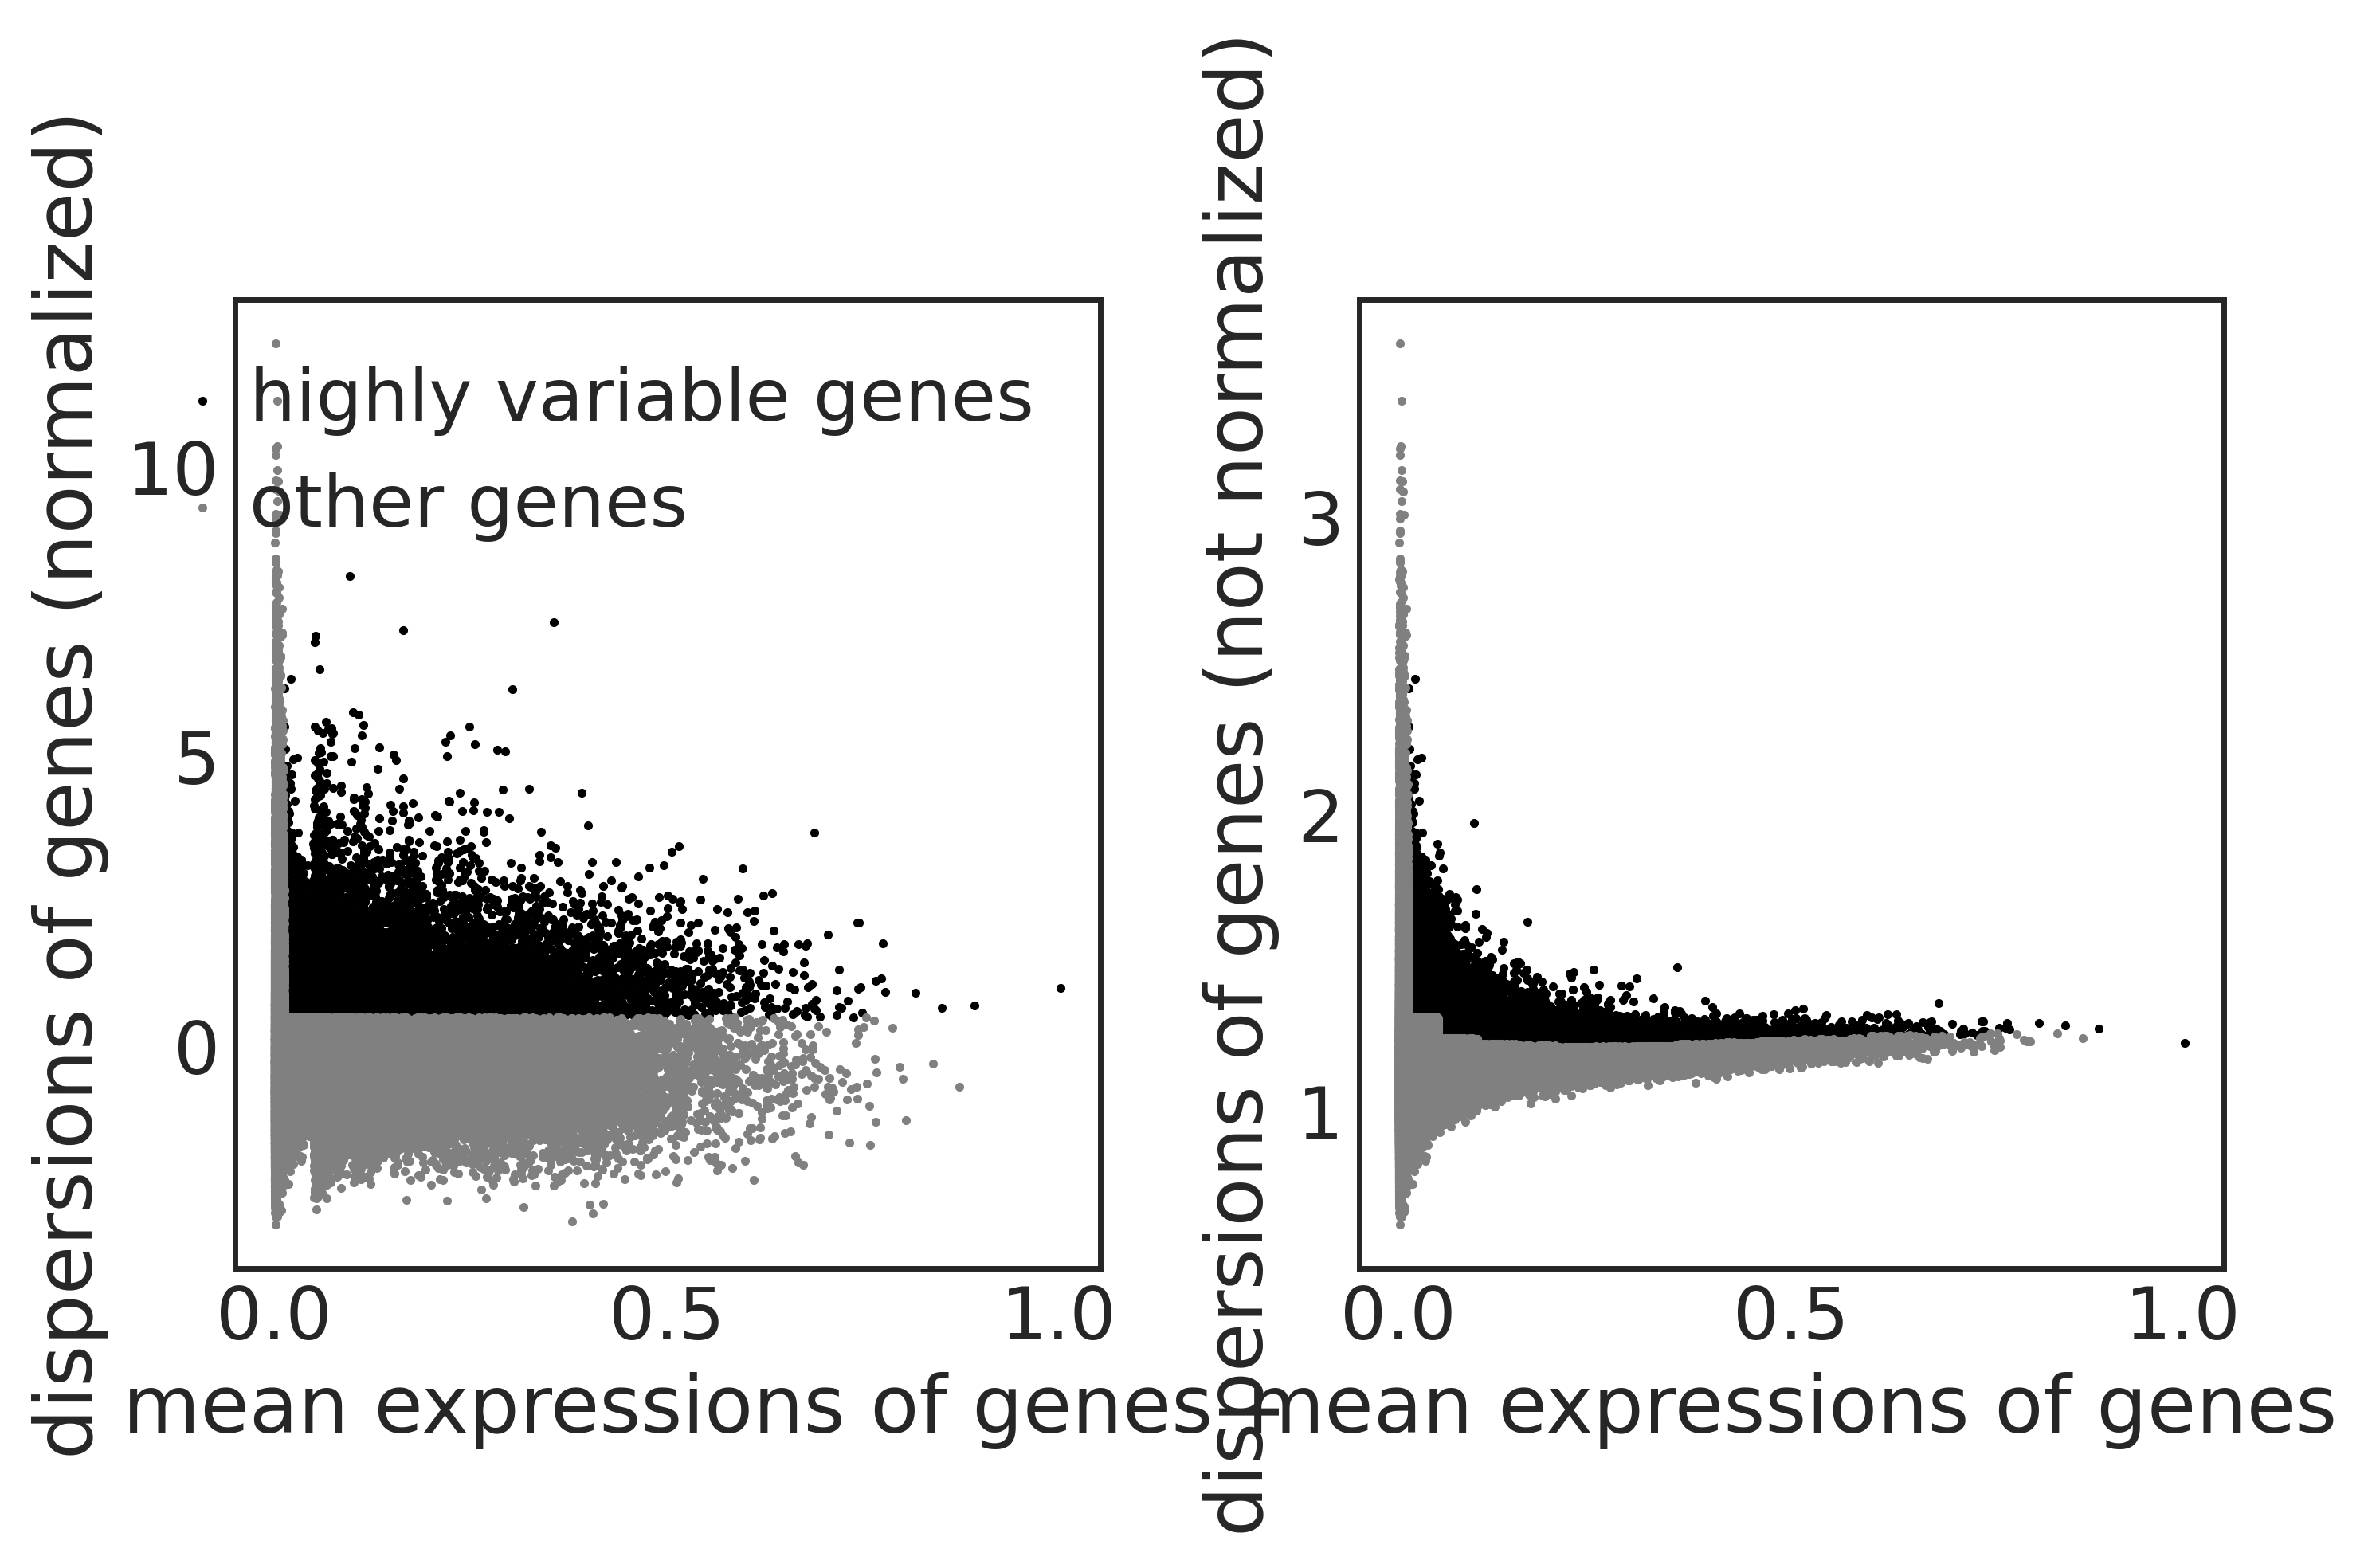

/home/gaw006/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/gaw006/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


(5202, 361076)
(3995, 361076)
(4689, 361076)
(5338, 361076)
(5759, 361076)
(5452, 361076)
(8426, 361076)
(5004, 361076)
(12001, 361076)
(7620, 361076)
(12669, 361076)
(7023, 361076)
(5172, 361076)
(7603, 361076)
(5423, 361076)
(7537, 361076)
(4968, 361076)
(5166, 361076)
(5518, 361076)
(5590, 361076)
(6194, 361076)
(4917, 361076)
(7132, 361076)
(6162, 361076)
(5938, 361076)
(7171, 361076)
(4042, 361076)
(6240, 361076)
(6845, 361076)
(7039, 361076)
(5149, 361076)
(7097, 361076)
(8883, 361076)
(6009, 361076)
25194


/home/gaw006/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/gaw006/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [9]:
## identify highly variable peaks
adata_merged_filter = sc.pp.filter_genes_dispersion(adata_merged.X, flavor='seurat', n_bins=20)
sc.pl.filter_genes_dispersion(adata_merged_filter, log=False, show=None, save=None)
hvgs = adata_merged.var.loc[adata_merged_filter.gene_subset].index.tolist()

samples_all=sorted(set(adata_merged.obs['donor']))
for sample in samples_all:
    print((adata_merged[adata_merged.obs.index.str.contains(sample+'_'),:].shape))
    adata_merged.var[sample] = (adata_merged_raw.X > 0)[adata_merged.obs.index.str.contains(sample+'_'),:].sum(axis=0).A1
hvgs = adata_merged.var.loc[adata_merged.var.index.isin(hvgs)]
hvgs = hvgs.loc[(hvgs>0).sum(axis=1)>(len(samples_all)-1)].index ### sample_all
adata_merged.var = adata_merged.var.drop(samples_all, axis=1)
print(len(hvgs))

## save highly variable peaks
bar_temp=adata_merged.obs.index[0]
hv_h5ad=adata_merged[adata_merged.obs.index.str.contains(bar_temp), :]
hv_h5ad1=hv_h5ad[:, hv_h5ad.var.index.isin(hvgs)]
hv_h5ad1.write('/oasis/tscc/scratch/gaw006/share/biobank_snATACseq/temp/hvgs.h5ad') 


In [10]:
## loading count matrix and highly variable peaks
adata_merged=sc.read('/projects/sanderlab/gaowei/snATAC_QC/final/h5ad_raw/all_raw_macs2.h5ad')
adata_merged_orig = adata_merged.copy()
adata_merged_raw = sc.pp.log1p(adata_merged, copy=True)
sc.pp.normalize_per_cell(adata_merged, counts_per_cell_after=1e4)

hvgs_adata=sc.read('/oasis/tscc/scratch/gaw006/share/biobank_snATACseq/temp/hvgs.h5ad')
hvgs=hvgs_adata.var.index
hvgs

Index(['1:100009692-100010523', '1:100056243-100056880',
       '1:100150933-100151771', '1:100231680-100232472',
       '1:100315024-100316302', '1:100434852-100436233',
       '1:100503099-100504840', '1:100598003-100599181',
       '1:100654016-100654874', '1:100714727-100716165',
       ...
       'X:9713373-9714940', 'X:97322654-97323645', 'X:9775229-9776216',
       'X:9816536-9817687', 'X:99890718-99892161', 'X:9989457-9990993',
       'X:99903910-99905435', 'X:9998149-9999345', 'X:99986148-99987445',
       'Y:59019638-59020382'],
      dtype='object', name='index', length=25194)

In [11]:
## data regression
adata_ind = {}
for sample in sorted(set(adata_merged.obs['donor'])):
    adata_ind[sample] = adata_merged[adata_merged.obs.index.str.contains(sample + '_'), :]
    adata_ind[sample] = adata_ind[sample][:, adata_ind[sample].var.index.isin(hvgs)]
    adata_ind[sample].obs['norm_log_counts'] = np.log(adata_ind[sample].X.sum(axis=1).A1)  ###1,norm_log_counts
    print(adata_ind[sample].X.shape)
    
    sc.pp.log1p(adata_ind[sample])
    adata_ind_orig = adata_merged_orig[adata_merged_orig.obs.index.str.contains(sample + '_'), :]
    adata_ind[sample].obs['log10_usable_counts'] = np.log10(adata_ind_orig[:, adata_ind_orig.var.index.isin(hvgs)].X.sum(axis=1).A1)
    adata_ind[sample].obs['log_usable_counts'] = np.log(adata_ind_orig[:, adata_ind_orig.var.index.isin(hvgs)].X.sum(axis=1).A1)
    sc.pp.regress_out(adata_ind[sample], ['log_usable_counts'])
    sc.pp.scale(adata_ind[sample]) 
    
    adata_ind[sample].write('/oasis/tscc/scratch/gaw006/share/biobank_snATACseq/temp/{}_reg.h5ad'.format(sample))
    adata_ind[sample]=None
    gc.collect()

adata_merged_orig = adata_ind_orig = None
gc.collect()

## aggregate cells from all donors
wd = '/oasis/tscc/scratch/gaw006/share/biobank_snATACseq/temp'
samples_all = ['JYH792','JYH809','MM12','MM51','MM54','MM55','MM56','MM57','MM59','MM60','MM61','MM77','MM78','MM79','MM80','MM81','MM86','MM87','MM88','MM89','MM93','MM94','MM95','MM96','MM97','MM98','MM108','MM109','MM110','MM120','MM121','MM122','MM123','MM124']

adatas = {}
for sample in sorted(samples_all):
    adatas[sample]=sc.read(os.path.join(wd,'{}_reg.h5ad'.format(sample))) 
adata_norm = AnnData.concatenate(adatas['JYH792'],adatas['JYH809'],adatas['MM108'],adatas['MM109'],adatas['MM110'],adatas['MM12'],adatas['MM120'],adatas['MM121'], adatas['MM122'],adatas['MM123'],adatas['MM124'],adatas['MM51'],adatas['MM54'],adatas['MM55'],adatas['MM56'],adatas['MM57'],adatas['MM59'],adatas['MM60'],adatas['MM61'],adatas['MM77'],adatas['MM78'],adatas['MM79'],adatas['MM80'],adatas['MM81'],adatas['MM86'],adatas['MM87'],adatas['MM88'],adatas['MM89'],adatas['MM93'],adatas['MM94'],adatas['MM95'],adatas['MM96'],adatas['MM97'],adatas['MM98'],join='inner',batch_key='donor', index_unique=None)
adatas=None
sc.pp.scale(adata_norm)
adata_norm.write('/oasis/tscc/scratch/gaw006/share/biobank_snATACseq/temp/all_norm.h5ad')

/home/gaw006/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/gaw006/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Trying to set attribute `.obs` of view, copying.


(5202, 25194)


Trying to set attribute `.obs` of view, copying.


(3995, 25194)


Trying to set attribute `.obs` of view, copying.


(4689, 25194)


Trying to set attribute `.obs` of view, copying.


(5338, 25194)


Trying to set attribute `.obs` of view, copying.


(5759, 25194)


Trying to set attribute `.obs` of view, copying.


(5452, 25194)


Trying to set attribute `.obs` of view, copying.


(8426, 25194)


Trying to set attribute `.obs` of view, copying.


(5004, 25194)


Trying to set attribute `.obs` of view, copying.


(12001, 25194)


Trying to set attribute `.obs` of view, copying.


(7620, 25194)


Trying to set attribute `.obs` of view, copying.


(12669, 25194)


Trying to set attribute `.obs` of view, copying.


(7023, 25194)


Trying to set attribute `.obs` of view, copying.


(5172, 25194)


Trying to set attribute `.obs` of view, copying.


(7603, 25194)


Trying to set attribute `.obs` of view, copying.


(5423, 25194)


Trying to set attribute `.obs` of view, copying.


(7537, 25194)


Trying to set attribute `.obs` of view, copying.


(4968, 25194)


Trying to set attribute `.obs` of view, copying.


(5166, 25194)


Trying to set attribute `.obs` of view, copying.


(5518, 25194)


Trying to set attribute `.obs` of view, copying.


(5590, 25194)


Trying to set attribute `.obs` of view, copying.


(6194, 25194)


Trying to set attribute `.obs` of view, copying.


(4917, 25194)


Trying to set attribute `.obs` of view, copying.


(7132, 25194)


Trying to set attribute `.obs` of view, copying.


(6162, 25194)


Trying to set attribute `.obs` of view, copying.


(5938, 25194)


Trying to set attribute `.obs` of view, copying.


(7171, 25194)


Trying to set attribute `.obs` of view, copying.


(4042, 25194)


Trying to set attribute `.obs` of view, copying.


(6240, 25194)


Trying to set attribute `.obs` of view, copying.


(6845, 25194)


Trying to set attribute `.obs` of view, copying.


(7039, 25194)


Trying to set attribute `.obs` of view, copying.


(5149, 25194)


Trying to set attribute `.obs` of view, copying.


(7097, 25194)


Trying to set attribute `.obs` of view, copying.


(8883, 25194)


Trying to set attribute `.obs` of view, copying.


(6009, 25194)


In [12]:
#### PCA
adata_norm=sc.read('/oasis/tscc/scratch/gaw006/share/biobank_snATACseq/temp/all_norm.h5ad')
adata_merged=None
adata_merged_raw=None
sc.tl.pca(adata_norm, zero_center=False, random_state=0,svd_solver='arpack')
pc = pd.DataFrame(adata_norm.obsm['X_pca'], columns=['PC{}'.format(i) for i in range(1,51)], index=adata_norm.obs.index)
donor = adata_norm.obs['donor'].tolist()


In [13]:
%%R -i pc -i donor -o harmonized
# -o var, get var from R
# -i var, get var from python

#.libPaths(c('/usr/lib64/R/library','/usr/share/R/library'))
#library(devtools)
#install_github("immunogenomics/harmony")

library(harmony)
library(magrittr)

meta_data=matrix(0,length(donor),2)
meta_data[,1]=as.character(donor)
meta_data[,2]=rownames(pc)
colnames(meta_data)=c('donor','cell')
meta_data=as.data.frame(meta_data)
class(meta_data)

batch <- as.factor(unlist(donor))
harmonized <- HarmonyMatrix(pc, meta_data,vars_use='donor',do_pca=FALSE)
harmonized <- data.frame(harmonized)

R[write to console]: Loading required package: Rcpp

R[write to console]: Harmony 1/10

R[write to console]: 0%   10   20   30   40   50   60   70   80   90   100%

R[write to console]: [----|----|----|----|----|----|----|----|----|----|

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[

In [14]:
# cell cluster UMAP
adata_norm.obsm['X_pca'] = harmonized.values
sc.pp.neighbors(adata_norm, n_neighbors=30, method='umap', metric='cosine', random_state=0, n_pcs=50) ##30, 50
sc.tl.leiden(adata_norm, resolution=1, random_state=0) ###resolution 1.5
sc.tl.umap(adata_norm, min_dist=0.3, random_state=0)   ###0.3
#adata_norm.write('/projects/sanderlab/gaowei/snATAC_QC/final/data/cell_cluster/snATAC_all_final.h5ad')

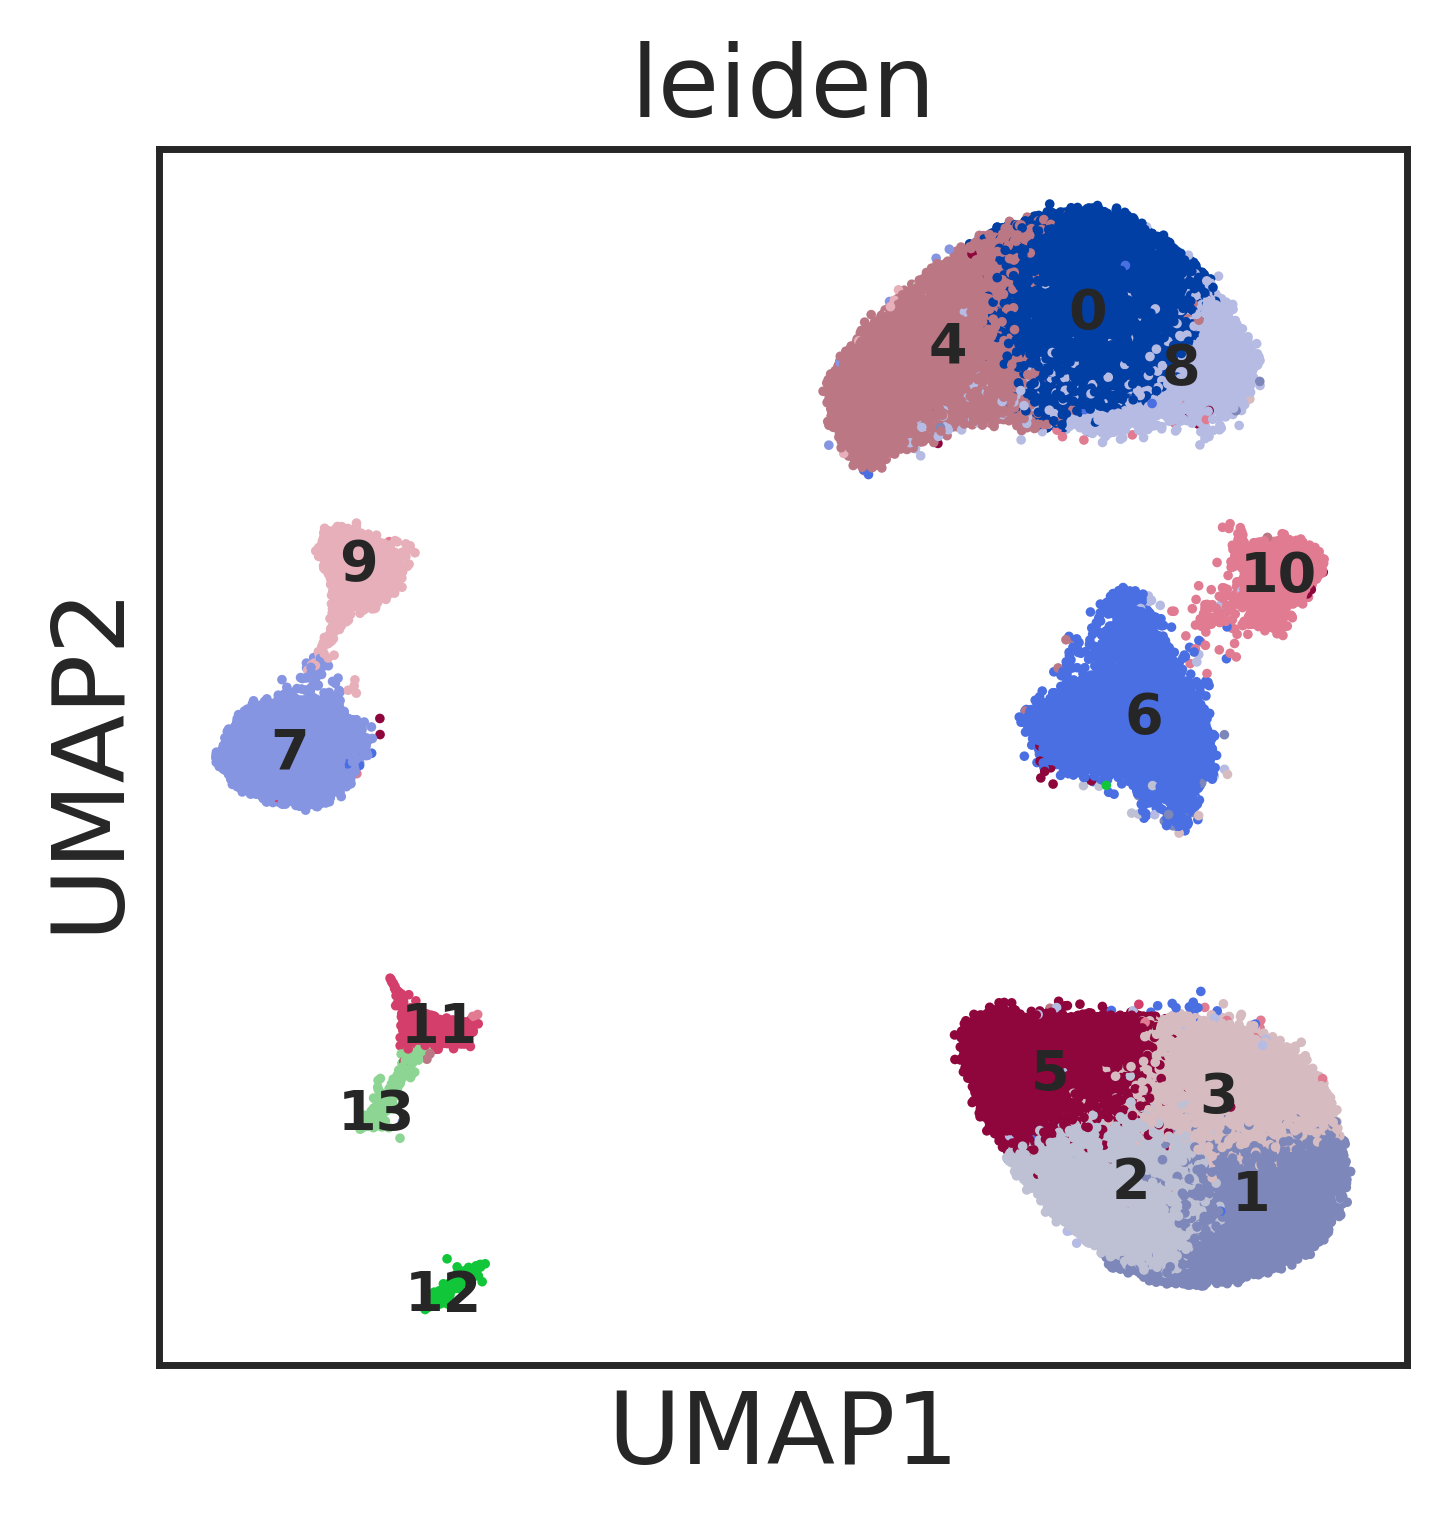

In [17]:

sc.pl.umap(adata_norm, color=['leiden'], size=12,color_map='Blues',legend_loc='on data',legend_fontsize=10)
